# Instacart Market Basket Analysis

### Which products will an Instacart consumer purchase again?

## Supervised Learning Capstone

 Author: Nutan Mandale

Mentor:Vincent Ramdhanie

### Data

The dataset is a relational set of files describing customers' orders over time. The goal of the notebook is to predict if products will be reordered in user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, is provided between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. 


In all there are 7 csv files out of which I have used 5 files considering their relevance for the analysis. Joining these tables was giving a data with 32 million records.
Understanding the limitations of the machine I am working on I took sample of 10% of the data set. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import gc # for garbage collection
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, make_scorer,accuracy_score,roc_curve,auc
from sklearn import tree
from sklearn import linear_model
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import pydotplus
import graphviz

from sklearn.neighbors import KNeighborsClassifier
color = sns.color_palette()

%matplotlib inline

In [2]:
# Merge Frames
#JOIN the order DF to the order_product DF on the order_id
orders_df = pd.read_csv("./orders.csv")
order_products__prior_df = pd.read_csv("./order_products__prior.csv")
order_product = pd.merge(orders_df, order_products__prior_df, how='inner', on='order_id')

#now delete the unnecessary things to save memory
del orders_df
del order_products__prior_df
gc.collect()

21

In [3]:
order_product.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0


In [4]:
#merge the product details
products_df = pd.read_csv("./products.csv")
order_product_full = pd.merge(order_product, products_df, how='inner', on='product_id')
del order_product
del products_df
gc.collect()

47

In [5]:
#merge the aisle info
aisles_df =  pd.read_csv("./aisles.csv")
with_aisles = pd.merge(order_product_full, aisles_df, how='inner', on='aisle_id')
print(with_aisles.shape)

#Reduce the number of rows to 3000000
#with_aisles = with_aisles[:3000000]
del order_product_full
del aisles_df
gc.collect()

(32434489, 14)


21

In [6]:
#merge department info
departments_df =  pd.read_csv("./departments.csv")
df = pd.merge(with_aisles, departments_df, how='inner', on='department_id')
del with_aisles
del departments_df
gc.collect()

21

In [7]:
df.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,soft drinks,beverages


### Exploratory Data Analysis

Let us do the exploratory data analysis by observing all the available features.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 15 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
product_id                int64
add_to_cart_order         int64
reordered                 int64
product_name              object
aisle_id                  int64
department_id             int64
aisle                     object
department                object
dtypes: float64(1), int64(10), object(4)
memory usage: 3.9+ GB


Let us see number of orders at different time of the day.

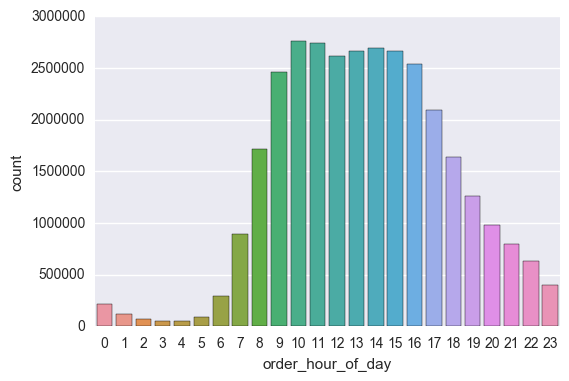

In [9]:
sns.countplot(x='order_hour_of_day', data=df);

We can see 9 am to 4 pm we  see highest traffic of the shoppers.

Let us see number of orders on different days of the week.

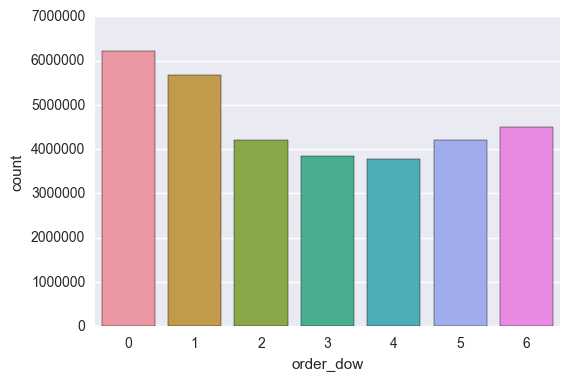

In [10]:
sns.countplot(x = 'order_dow',data=df);

From the above plot we can say that on Wednesday and Thursday there is leats shopping and Sunday is the popular day for the shopping.

Let us see the unique products.

In [11]:
df.product_name.unique()

array(['Soda', 'Zero Calorie Cola',
       'Diet Caffeine Free Naturally Flavored Lemon Lime Soda', ...,
       'Super Nutty Granola', 'Organic Wheat Bran', 'Organic Emmer Farro'], dtype=object)

In [12]:
count = len(df.product_name.unique())
print(count)

49677


In [13]:
df[df['reordered'] == 1].count()

order_id                  19126536
user_id                   19126536
eval_set                  19126536
order_number              19126536
order_dow                 19126536
order_hour_of_day         19126536
days_since_prior_order    19126536
product_id                19126536
add_to_cart_order         19126536
reordered                 19126536
product_name              19126536
aisle_id                  19126536
department_id             19126536
aisle                     19126536
department                19126536
dtype: int64

In [14]:
df[df['reordered'] == 0].count()

order_id                  13307953
user_id                   13307953
eval_set                  13307953
order_number              13307953
order_dow                 13307953
order_hour_of_day         13307953
days_since_prior_order    11229885
product_id                13307953
add_to_cart_order         13307953
reordered                 13307953
product_name              13307953
aisle_id                  13307953
department_id             13307953
aisle                     13307953
department                13307953
dtype: int64

From the plot below we find that number of reordered products is very high.

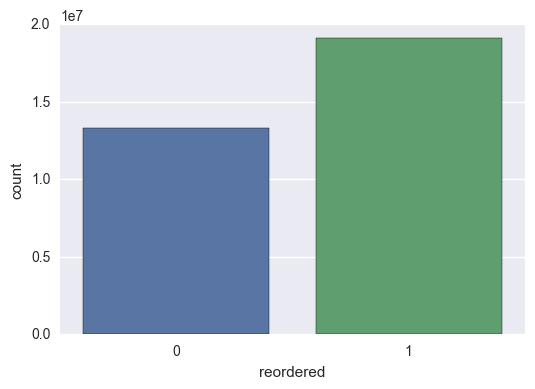

In [15]:
sns.countplot(x='reordered', data=df);

Let us see what products are ordered more often.

In [16]:
df = df.dropna()

In [17]:
frq_reorder = df['product_name'].value_counts().reset_index()
frq_reorder.columns = ['product_name','count']
frq_reorder.head()

,product_name,count
0,Banana,443031
1,Bag of Organic Bananas,360292
2,Organic Strawberries,248219
3,Organic Baby Spinach,226973
4,Organic Hass Avocado,202478


In [18]:
frq_reorder.shape

(49646, 2)

In [19]:
df.aisle .unique()

array(['soft drinks', 'juice nectars', 'refrigerated', 'tea',
       'water seltzer sparkling water', 'coffee', 'cocoa drink mixes',
       'energy sports drinks', 'soy lactosefree', 'packaged cheese',
       'cream', 'yogurt', 'other creams cheeses', 'milk', 'eggs', 'butter',
       'specialty cheeses', 'refrigerated pudding desserts',
       'popcorn jerky', 'nuts seeds dried fruit', 'candy chocolate',
       'crackers', 'chips pretzels', 'energy granola bars',
       'fruit vegetable snacks', 'cookies cakes', 'trail mix snack mix',
       'mint gum', 'ice cream toppings', 'paper goods', 'dish detergents',
       'plates bowls cups flatware', 'more household', 'food storage',
       'air fresheners candles', 'kitchen supplies', 'laundry',
       'cleaning products', 'trash bags liners', 'fresh fruits',
       'packaged vegetables fruits', 'fresh vegetables', 'fresh herbs',
       'packaged produce', 'cereal', 'breakfast bars pastries', 'granola',
       'hot cereal pancake mixes', 's

In [20]:
count = len(df.aisle.unique())
print(count)

134


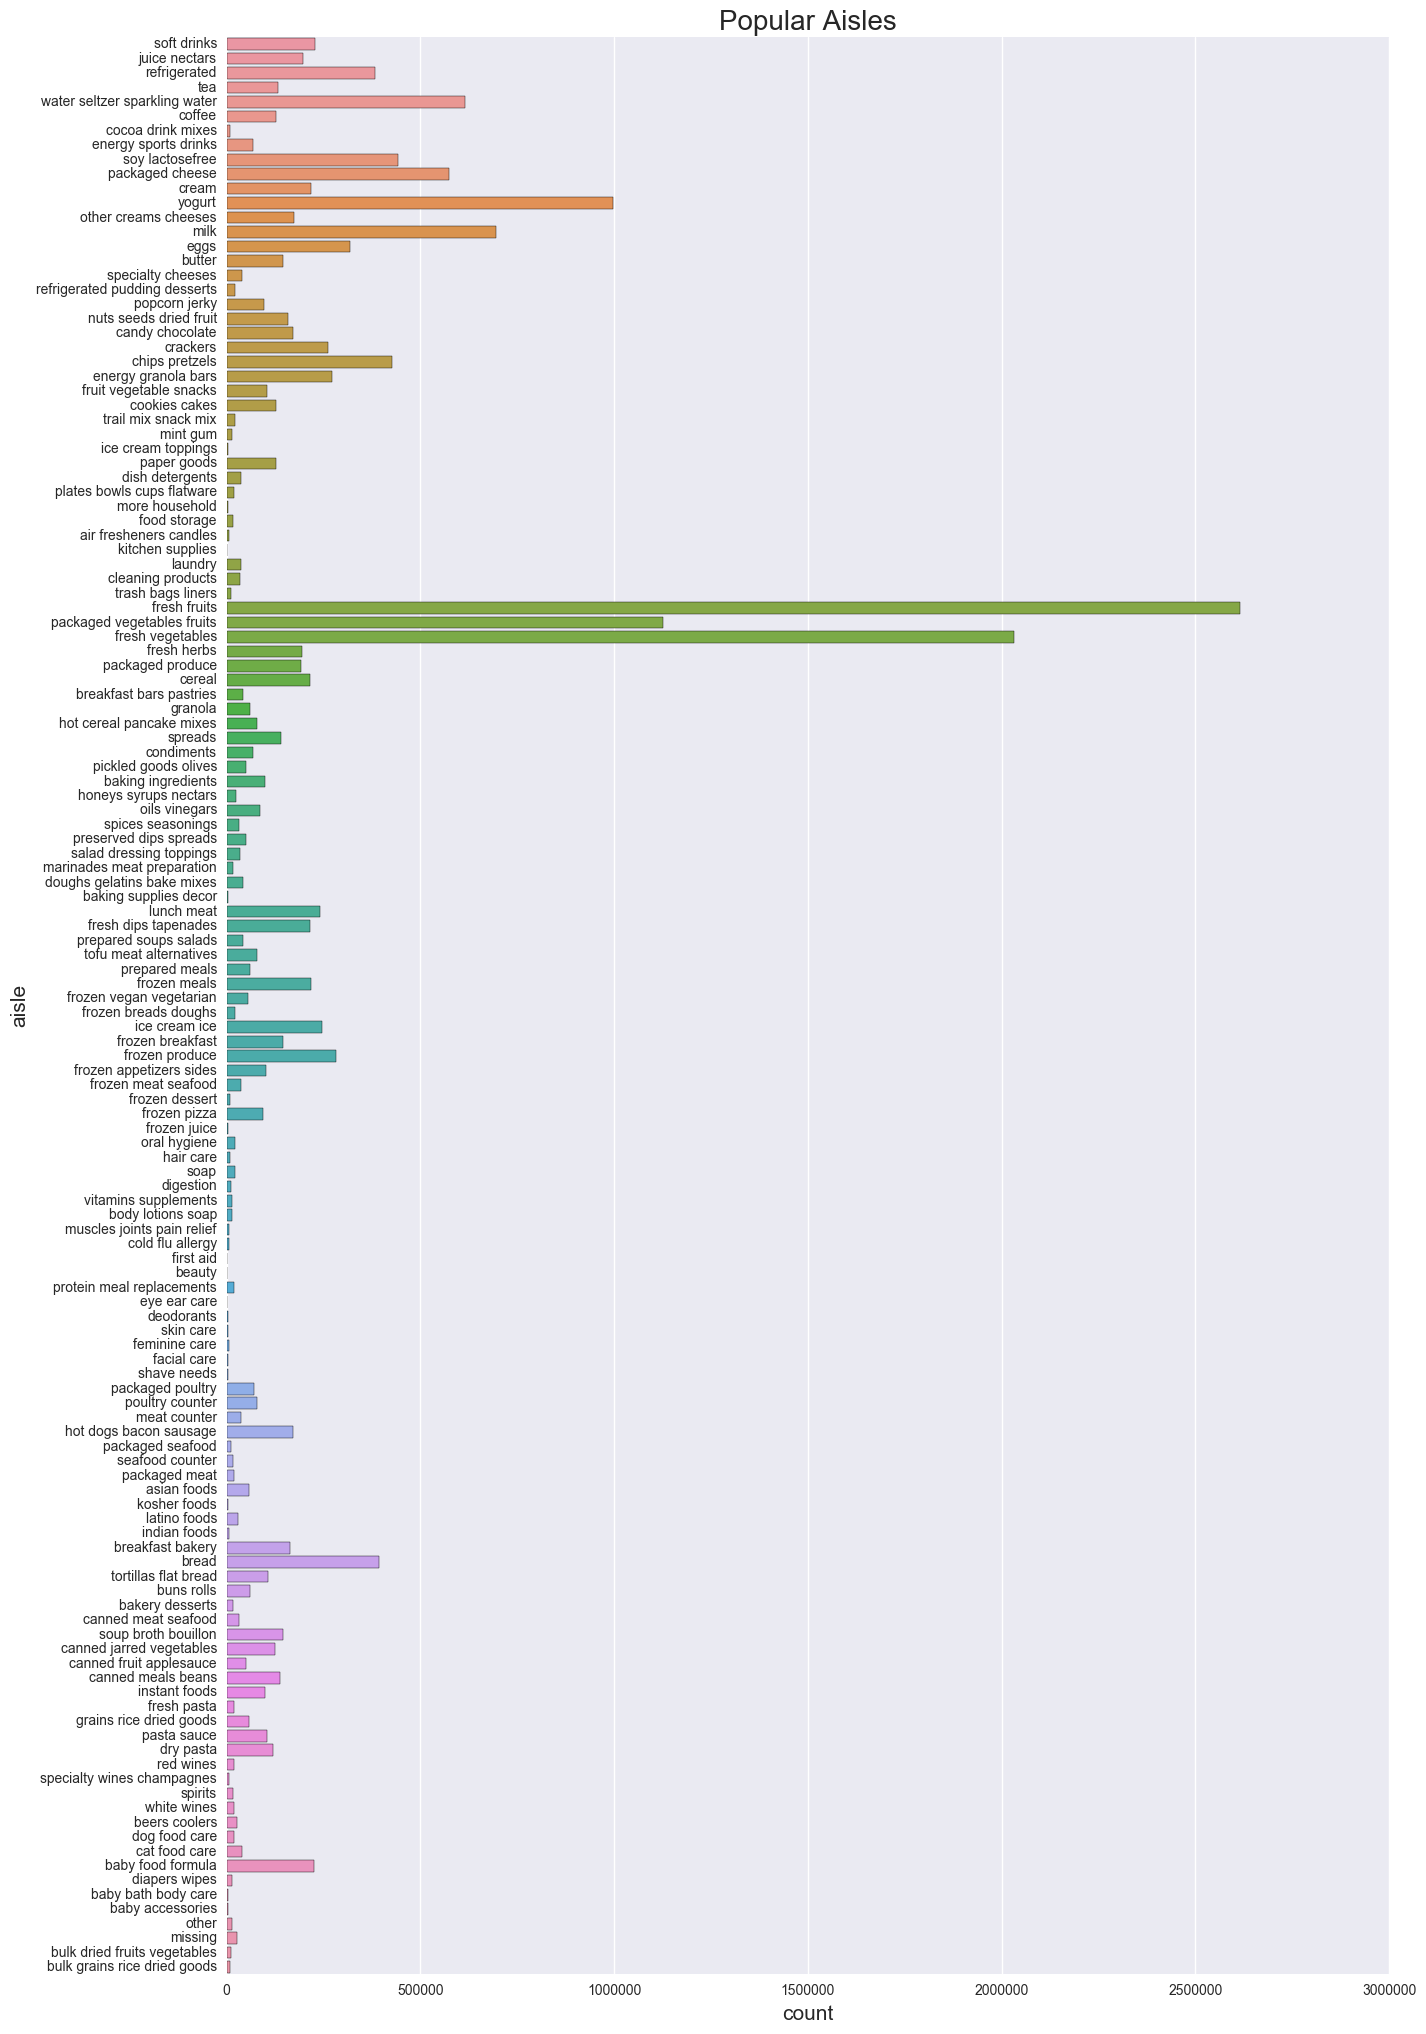

In [21]:
plt.figure(figsize=(15,25))
plt.xlabel('Count', fontsize=15)
plt.ylabel('Aisle', fontsize=15)
plt.title("Popular Aisles", fontsize=20)
sns.countplot(y="aisle", data=df[df['reordered'] == 1]);

Among all the given aisles we can see fresh fruits and vegetables are the most popular aisles.

In [22]:
df.department.unique()

array(['beverages', 'dairy eggs', 'snacks', 'household', 'produce',
       'breakfast', 'pantry', 'deli', 'frozen', 'personal care',
       'meat seafood', 'international', 'bakery', 'canned goods',
       'dry goods pasta', 'alcohol', 'pets', 'babies', 'other', 'missing',
       'bulk'], dtype=object)

In [23]:
count = len(df.department.unique())
print(count)

21


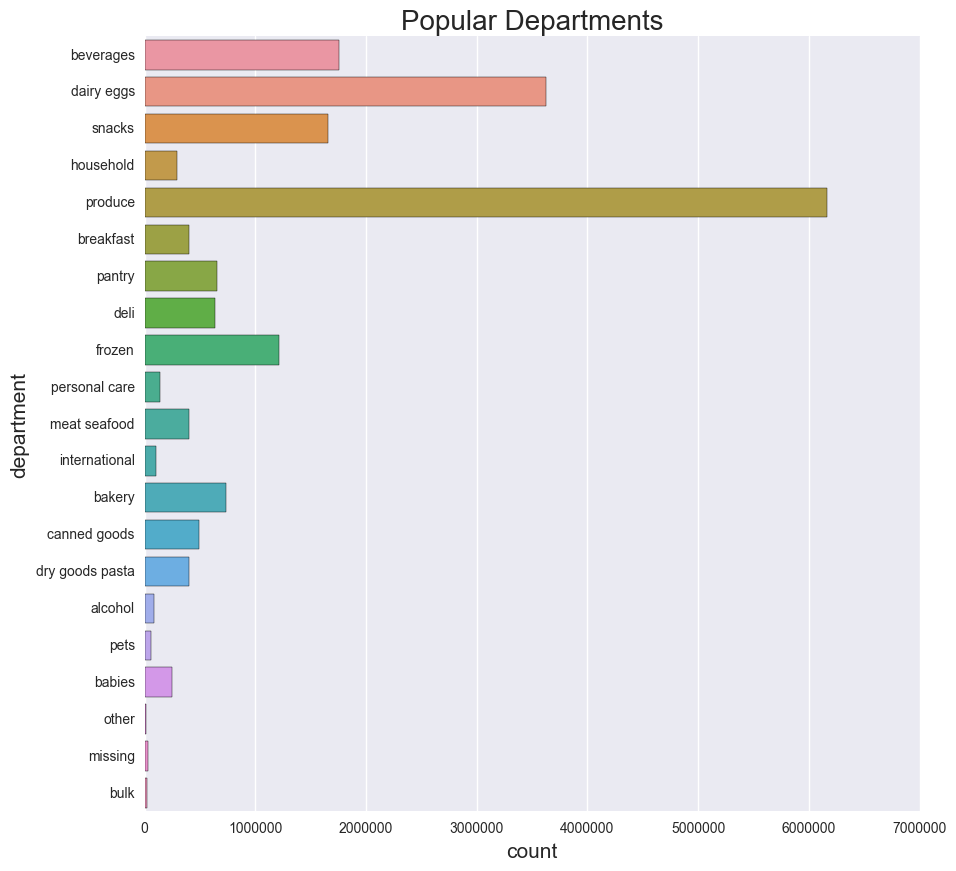

In [24]:
plt.figure(figsize=(10,10))
plt.xlabel('Count', fontsize=15)
plt.ylabel('Departments', fontsize=15)
plt.title("Popular Departments", fontsize=20)
sns.countplot(y="department", data=df[df['reordered'] == 1]);

Produce department is the most popular department.

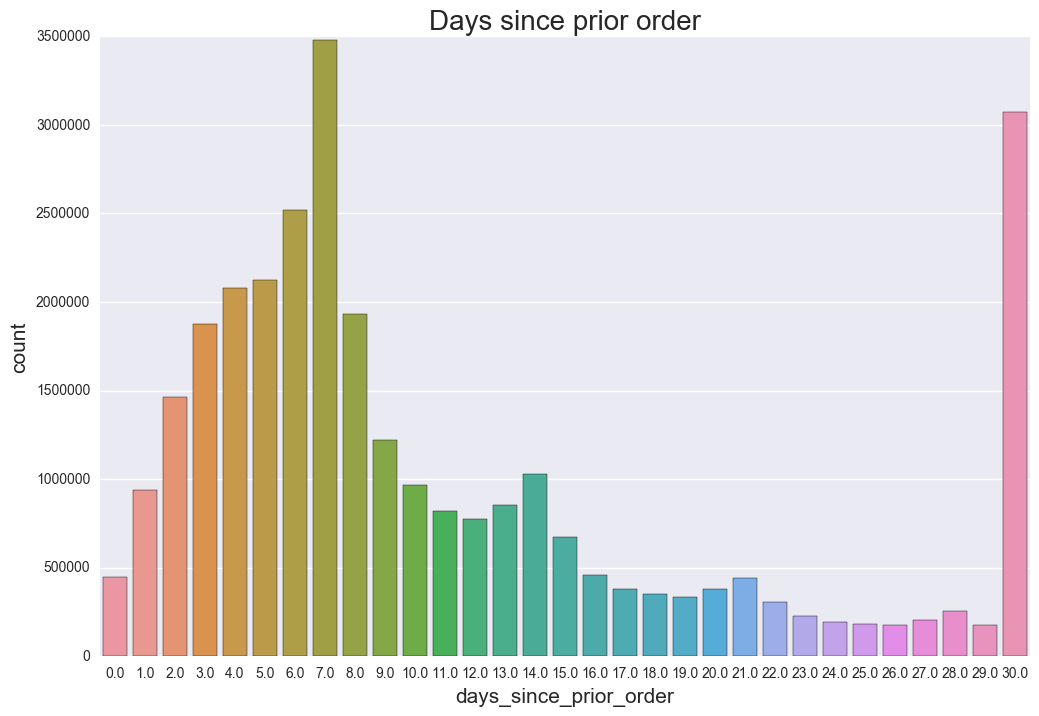

In [25]:
plt.figure(figsize=(12,8))
plt.xlabel('Days since prior order', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title("Days since prior order", fontsize=20)
sns.countplot(x ='days_since_prior_order', data=df);

We can see a pattern from the above plot that people order most on seventh day and 30th day. Let us see what are the popular departments where people shop most on 7th day

In [26]:
df_1 = df[df['days_since_prior_order'] == 7]
df_1.shape

(3479504, 15)

In [27]:
count = len(df_1.product_name.unique())
print(count)

42435


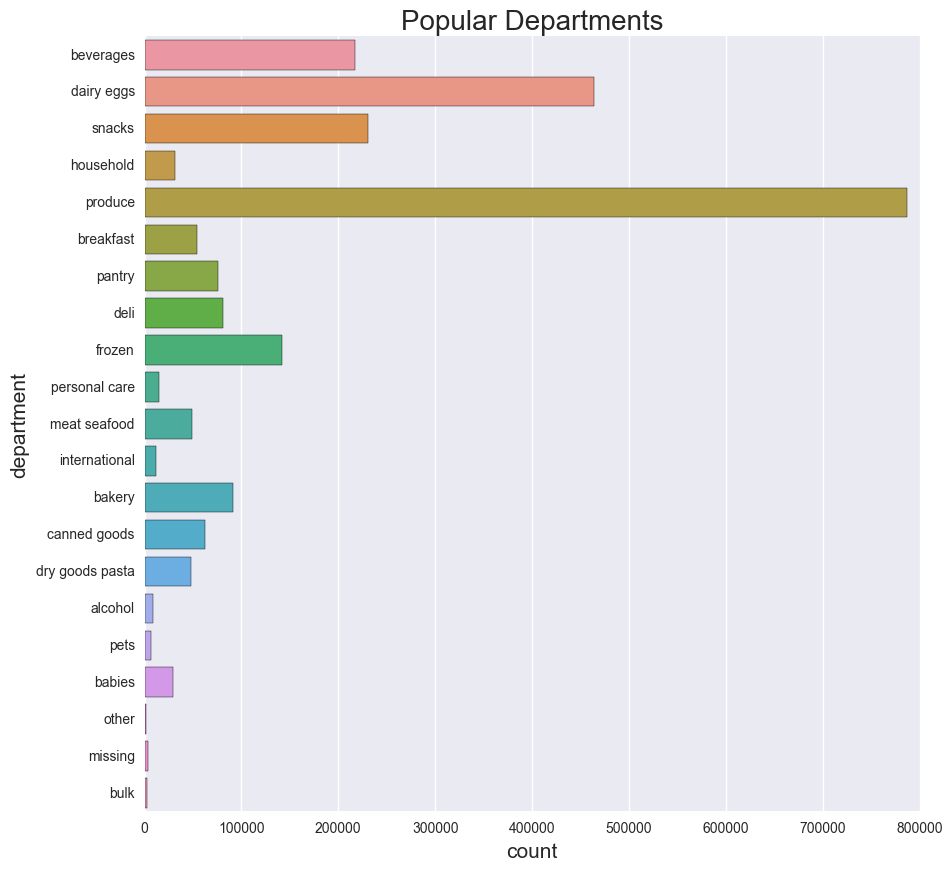

In [28]:
plt.figure(figsize=(10,10))
plt.xlabel('Count', fontsize=15)
plt.ylabel('Departments', fontsize=15)
plt.title("Popular Departments", fontsize=20)
sns.countplot(y="department", data=df_1[df_1['reordered'] == 1]);

Here we see the produce department is the popular for people to shop on 7th day. Similarly let us see the popular department for shoppers who shop on 30th day

In [29]:
df_2 = df[df['days_since_prior_order'] == 30]
df_2.shape

(3070057, 15)

In [30]:
count = len(df_2.product_name.unique())
print(count)

43698


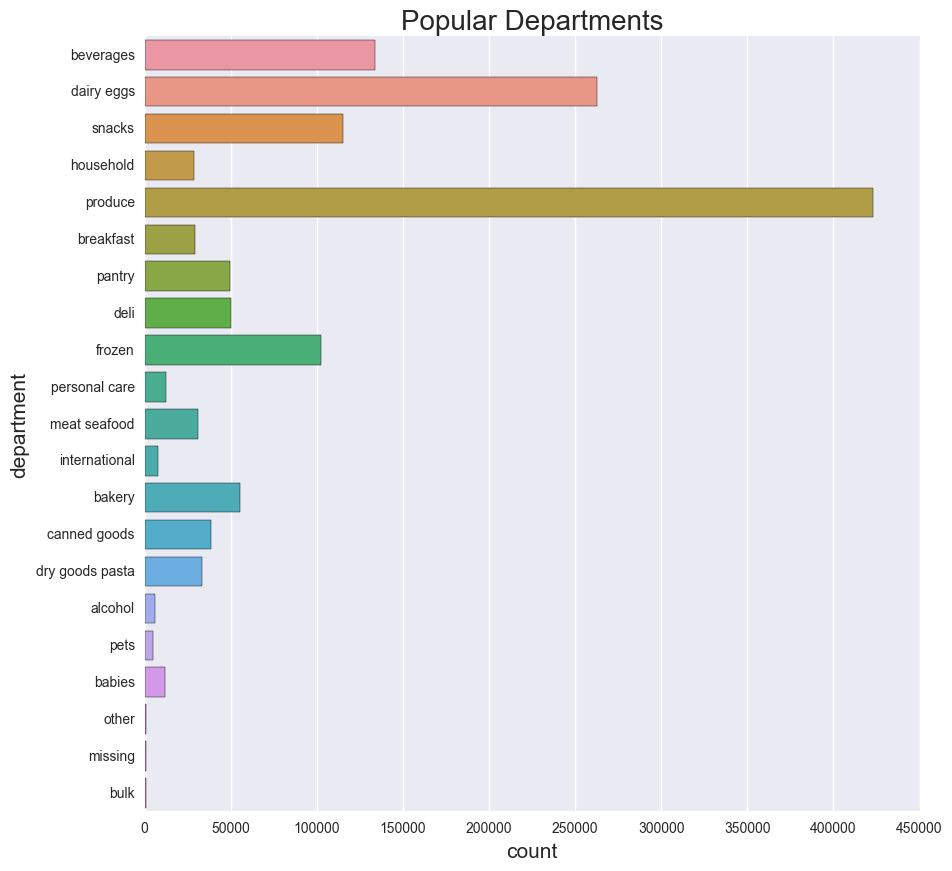

In [31]:
plt.figure(figsize=(10,10))
plt.xlabel('Count', fontsize=15)
plt.ylabel('Departments', fontsize=15)
plt.title("Popular Departments", fontsize=20)
sns.countplot(y="department", data=df_2[df_2['reordered'] == 1]);

Here we see the increase in the shopping of beverages and pantry items when shoppers shop on 30th day

### Models

Let us seperate our dependent and independent variables.

In [32]:
#reducing the sample size to 3000000 records
df = df[:3000000]

In [33]:
y = df.reordered

In [34]:
y.head()

1    1
2    1
3    1
4    1
5    1
Name: reordered, dtype: int64

In [35]:
X = df.drop(['reordered','eval_set','aisle','product_name','department','order_id','user_id'], axis=1)

In [36]:
X.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,aisle_id,department_id
1,2,3,7,15.0,196,1,77,7
2,3,3,12,21.0,196,1,77,7
3,4,4,7,29.0,196,1,77,7
4,5,4,15,28.0,196,1,77,7
5,6,2,7,19.0,196,1,77,7


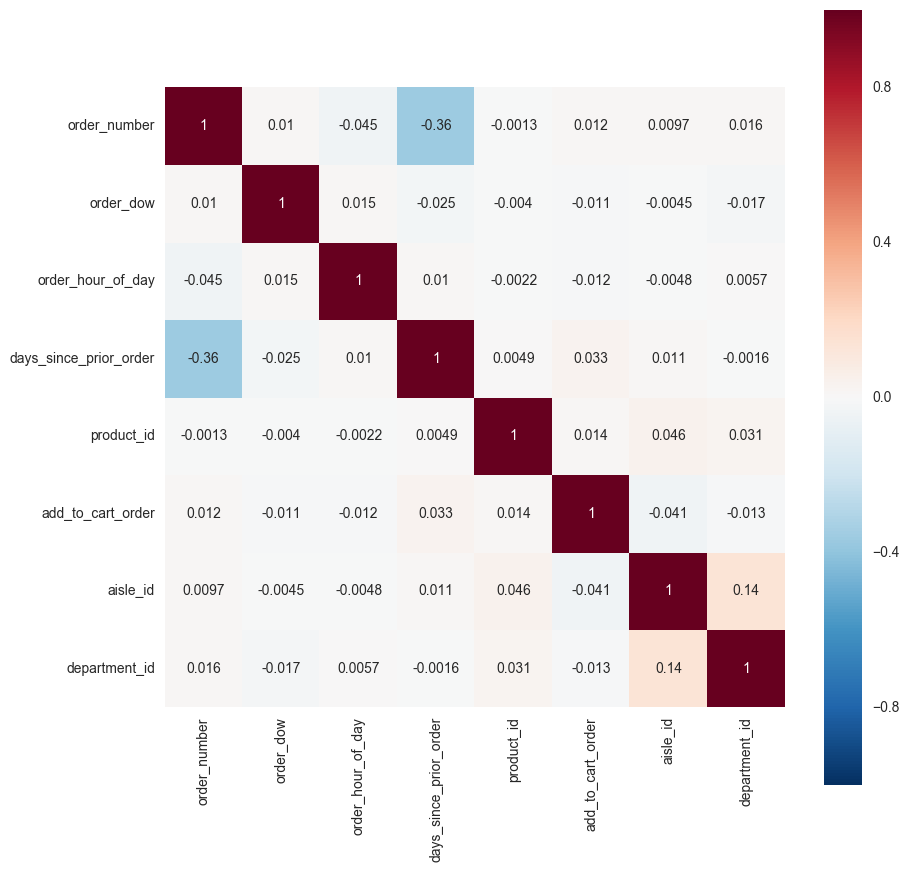

In [73]:
corr_mat=X.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_mat, vmax=1, square=True, annot=True);

In [38]:
X.dtypes

order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
product_id                  int64
add_to_cart_order           int64
aisle_id                    int64
department_id               int64
dtype: object

In [39]:
X.shape

(3000000, 8)

### Train test split of X and y.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=5)

## Regression Classifier

### Ridge Regression

In [41]:
#applying ridge regression model
ridgeregr = linear_model.RidgeClassifier(alpha=10, fit_intercept=False)
ridgeregr.fit(X_train, y_train)
print(ridgeregr.score(X_train, y_train))
y_train_pred_ridge = ridgeregr.predict(X_train)
y_test_pred_ridge = ridgeregr.predict(X_test)

0.714374222222


In [42]:
pred_y_ridge = ridgeregr.predict(X)

print('\n Accuracy')
print(pd.crosstab(pred_y_ridge, y))
print("\nAccuracy on training set:") 
print(ridgeregr.score(X_train, y_train))
print("\nAccuracy on test set:")
print(ridgeregr.score(X_test, y_test))
print('\nRMSE of test set: %.3f' % (np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_ridge))) )


 Accuracy
reordered       0        1
row_0                     
0           91989    59618
1          796835  2051558

Accuracy on training set:
0.714374222222

Accuracy on test set:
0.71494

RMSE of test set: 0.534


Confusion Matrix
 [[ 23106 198880]
 [ 14915 513099]]
[ 0.          0.89591235  1.        ] [ 0.          0.97175264  1.        ]
AUC for Ridge regression
 0.537920144045


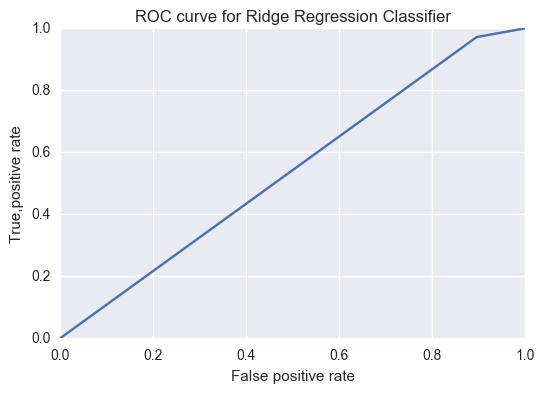

In [43]:
#confusion matrix
confusion = confusion_matrix(y_test, y_test_pred_ridge)

print('Confusion Matrix\n', confusion)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_ridge)
print(fpr,tpr)
#Area under curve
auc(fpr,tpr)
print('AUC for Ridge regression\n',auc(fpr,tpr))

plt.xlabel('False positive rate')
plt.ylabel('True,positive rate')
plt.title('ROC curve for Ridge Regression Classifier')
plt.plot(fpr,tpr);

### Logistic Regression

In [44]:
#applying logistic regression
lr = LogisticRegression(penalty='l2', C=0.001)
fit = lr.fit(X_train, y_train)
# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
y_lr = lr.predict(X_test)
print("\nAccuracy on training set:") 
print(lr.score(X_train, y_train))
print("\nAccuracy on test set:")
print(lr.score(X_test, y_test))

Coefficients
[[  3.98106475e-02  -1.08519712e-03   1.25233331e-02  -6.29275678e-03
    1.01739505e-06  -5.44019605e-02   3.03516662e-03   2.98004876e-02]]
[ 0.00330687]

Accuracy on training set:
0.719209333333

Accuracy on test set:
0.719194666667


Confusion Matrix
 [[ 31357 190629]
 [ 19975 508039]]
[ 0.          0.85874334  1.        ] [ 0.          0.96216956  1.        ]
AUC for Logistic regression classifier
 0.551713109755


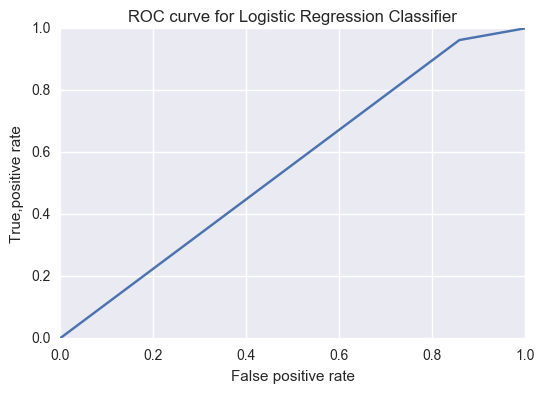

In [45]:
#confusion matrix
confusion = confusion_matrix(y_test, y_lr)

print('Confusion Matrix\n', confusion)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_lr)
print(fpr,tpr)
#Area under curve
auc(fpr,tpr)
print('AUC for Logistic regression classifier\n',auc(fpr,tpr))

plt.xlabel('False positive rate')
plt.ylabel('True,positive rate')
plt.title('ROC curve for Logistic Regression Classifier')
plt.plot(fpr,tpr);

### KNN Classifier

In [74]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred1 = knn.predict(X_test)
print('\nR-squared:')
print('%.3f' % (knn.score(X_train, y_train)) )


R-squared:
0.997


In [76]:
print ('Accuracy:\n',accuracy_score(y_test, y_pred1))
#confusion matrix
confusion = confusion_matrix(y_test, y_pred1)
print('Confusion Matrix:\n', confusion)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred1)
print(fpr,tpr)

print('AUC:\n',auc(fpr,tpr))

Accuracy:
 0.668729333333
Confusion Matrix:
 [[ 95943 126043]
 [122410 405604]]
[ 0.          0.56779707  1.        ] [ 0.          0.76816903  1.        ]
AUC:
 0.600185978769


In [47]:
#weighted knn
knn_w = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_w.fit(X_train, y_train)
y_pred = knn_w.predict(X_test)
print('\nR-squared:')
print('%.3f' % (knn_w.score(X_train, y_train)) )


R-squared:
0.997


In [48]:
print ('Accuracy:\n',accuracy_score(y_test, y_pred))
#confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', confusion)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(fpr,tpr)

print('AUC:\n',auc(fpr,tpr))

Accuracy:
 0.717308
Confusion Matrix:
 [[ 88461 133525]
 [ 78494 449520]]
[ 0.         0.6015019  1.       ] [ 0.          0.85134106  1.        ]
AUC:
 0.624919583205


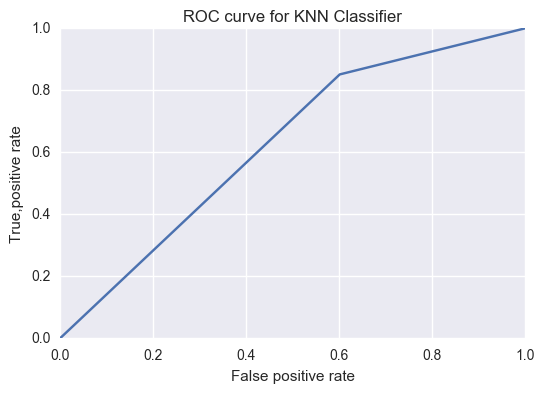

In [49]:
plt.xlabel('False positive rate')
plt.ylabel('True,positive rate')
plt.title('ROC curve for KNN Classifier')
plt.plot(fpr,tpr);

## Decision Tree Classifier

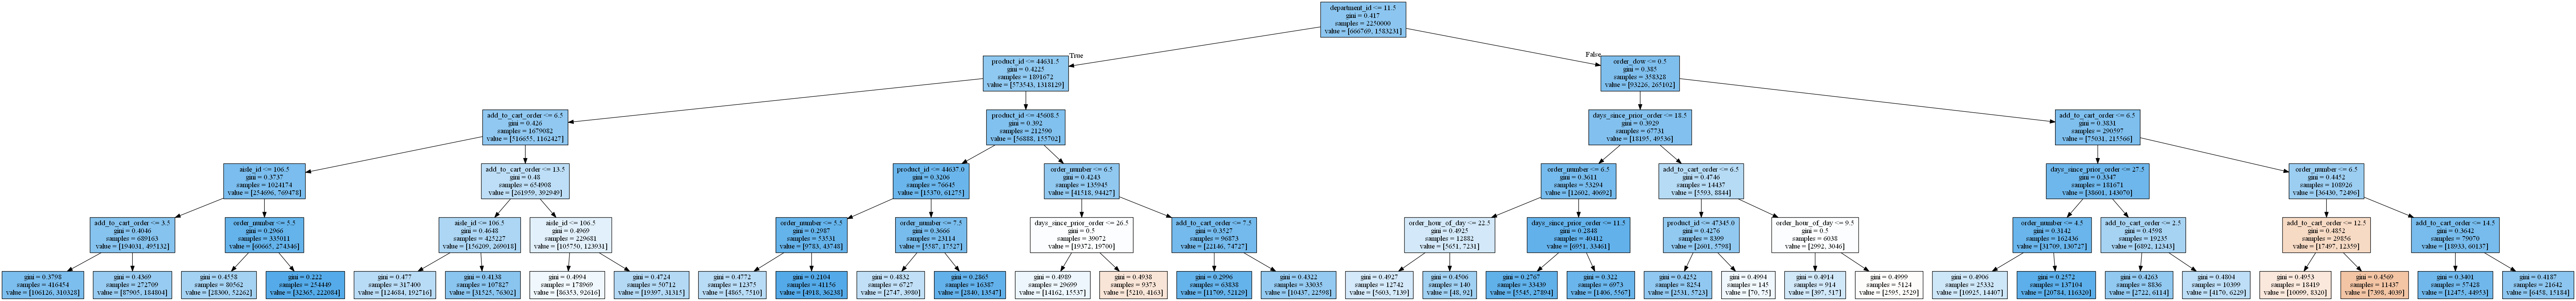

In [50]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=3)
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    max_features=3,
    max_depth=5,
    random_state = 1337
)

decision_tree.fit(X_train, y_train)
y_1_predictions = decision_tree.predict(X_test)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [51]:
print("\nAccuracy on training set: {:.3f}".format(decision_tree.score(X_train, y_train)))
print("\nAccuracy on test set: {:.3f}".format(decision_tree.score(X_test, y_test)))


Accuracy on training set: 0.706

Accuracy on test set: 0.707


Confusion Matrix
 [[  8401 213654]
 [  6365 521580]]
[ 0.          0.96216703  1.        ] [ 0.          0.98794382  1.        ]
AUC for Decision tree classifier
 0.512888394607


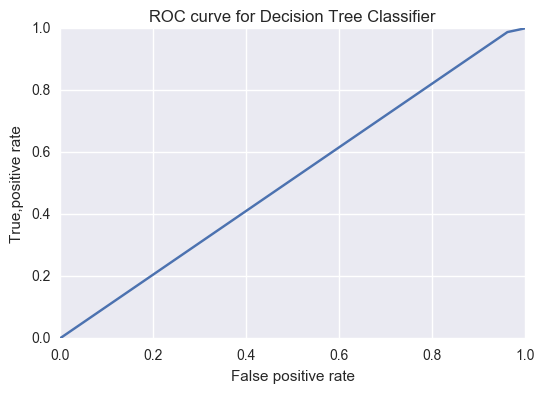

In [52]:
#confusion matrix
confusion = confusion_matrix(y_test, y_1_predictions)
print('Confusion Matrix\n', confusion)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_1_predictions)
print(fpr,tpr)
print('AUC for Decision tree classifier\n',auc(fpr,tpr))
plt.xlabel('False positive rate')
plt.ylabel('True,positive rate')
plt.title('ROC curve for Decision Tree Classifier')
plt.plot(fpr,tpr);

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.192095 to fit



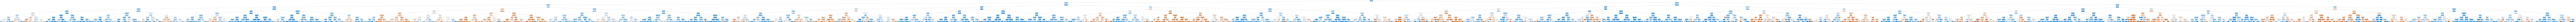

In [54]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    max_features=3,
    max_depth=10,
    random_state = 1337
)

decision_tree.fit(X_train, y_train)
y_2_predictions = decision_tree.predict(X_test)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [55]:
print("\nAccuracy on training set: {:.3f}".format(decision_tree.score(X_train, y_train)))
print("\nAccuracy on test set: {:.3f}".format(decision_tree.score(X_test, y_test)))


Accuracy on training set: 0.739

Accuracy on test set: 0.738


Confusion Matrix
 [[ 63043 159012]
 [ 37158 490787]]
AUC for Decision tree classifier
 0.512888394607
[ 0.          0.71609286  1.        ] [ 0.          0.92961767  1.        ]


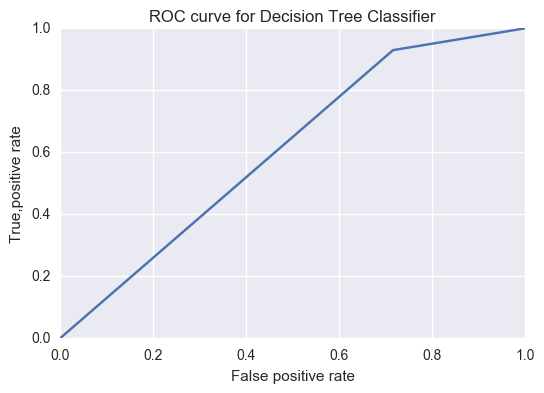

In [56]:
#confusion matrix
confusion = confusion_matrix(y_test, y_2_predictions)
print('Confusion Matrix\n', confusion)

auc(fpr,tpr)
print('AUC for Decision tree classifier\n',auc(fpr,tpr))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_2_predictions)
print(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('True,positive rate')
plt.title('ROC curve for Decision Tree Classifier')
plt.plot(fpr,tpr);

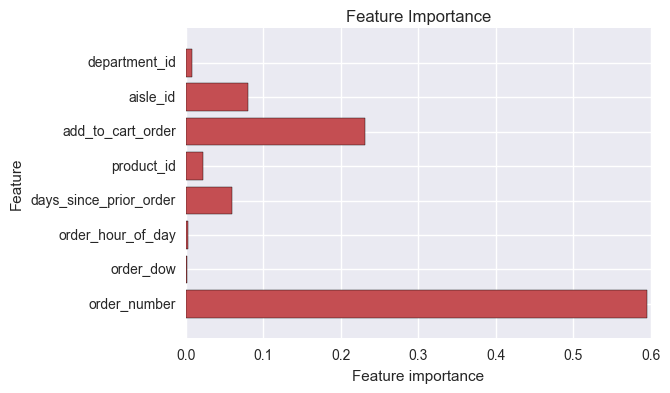

In [57]:
n_features = X.shape[1]
plt.figure()
plt.barh(range(n_features), decision_tree.feature_importances_, color=color[2],align='center')
plt.yticks(np.arange(n_features), X.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

### Gradient-boosted Classifier

In [58]:
clf = GradientBoostingClassifier().fit(X_train, y_train)
y_gb_predictions = clf.predict(X_test)
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of GBDT classifier on training set: 0.74
Accuracy of GBDT classifier on test set: 0.75


Confusion Matrix
 [[ 70514 151541]
 [ 39381 488564]]
AUC for Gradient boosted  classifier
 0.606762404315
[ 0.          0.68244804  1.        ] [ 0.        0.925407  1.      ]


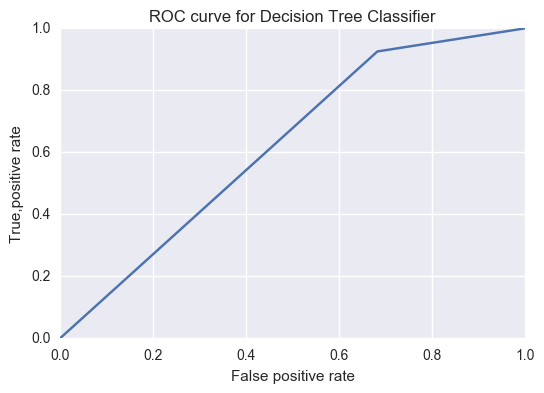

In [59]:
#confusion matrix
confusion = confusion_matrix(y_test, y_gb_predictions)
print('Confusion Matrix\n', confusion)
auc(fpr,tpr)
print('AUC for Gradient boosted  classifier\n',auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_gb_predictions)
print(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('True,positive rate')
plt.title('ROC curve for Decision Tree Classifier')
plt.plot(fpr,tpr);

### Bootstrap Aggregation (Bagging)

In [60]:
#Experiment with Bagging
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3)
bag = BaggingClassifier(
    base_estimator=tree, 
    n_estimators=500, 
    max_samples=1.0, 
    max_features=1.0, 
    bootstrap=True, 
    bootstrap_features=False, 
    n_jobs=-1)
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

# Without Bagging
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision Tree without Bagging: %.3f/%.3f' % (tree_train, tree_test))

# With Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('With Bagging: %.3f/%.3f' % (bag_train, bag_test))

Decision Tree without Bagging: 0.732/0.732
With Bagging: 0.734/0.734


Confusion Matrix
 [[121600 234167]
 [ 84935 759298]]
AUC for bagging
 0.621479480236
[ 0.          0.65820326  1.        ] [ 0.          0.89939389  1.        ]


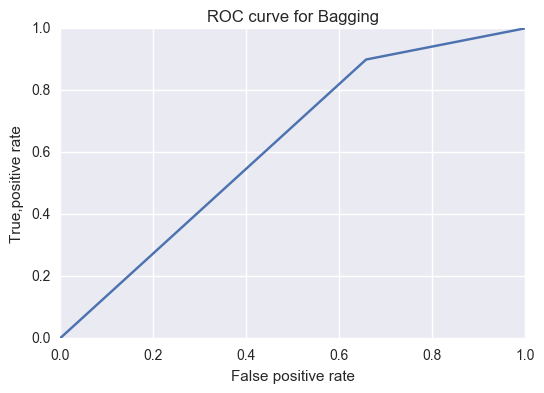

In [61]:
#confusion matrix
confusion = confusion_matrix(y_test, y_test_pred )
print('Confusion Matrix\n', confusion)
auc(fpr,tpr)
print('AUC for bagging\n',auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred )
print(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('True,positive rate')
plt.title('ROC curve for Bagging')
plt.plot(fpr,tpr);

## Random Forest Classifier

In [62]:
rfc = ensemble.RandomForestClassifier(
    n_estimators=15,
    max_features=3,
    max_depth=5
)

In [63]:
from sklearn.model_selection import cross_val_score, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=5)
rfc.fit(X_train, y_train)
y_predict = rfc.predict(X_test)

print("\nAccuracy on training set: {:.3f}".format(rfc.score(X_train, y_train)))
print("\nAccuracy on test set: {:.3f}".format(rfc.score(X_test, y_test)))


Accuracy on training set: 0.737

Accuracy on test set: 0.737


Confusion Matrix
 [[ 58821 163165]
 [ 33779 494235]]
[ 0.          0.73502383  1.        ] [ 0.          0.93602632  1.        ]
AUC for Random Forest  classifier
 0.600501243576


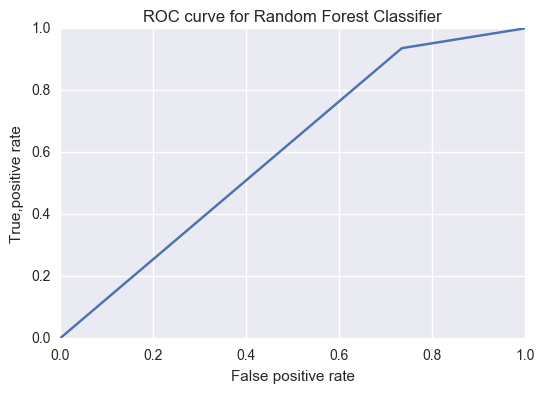

In [64]:
#confusion matrix
confusion = confusion_matrix(y_test, y_predict)

print('Confusion Matrix\n', confusion)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)
print(fpr,tpr)
#Area under curve
auc(fpr,tpr)
print('AUC for Random Forest  classifier\n',auc(fpr,tpr))

plt.xlabel('False positive rate')
plt.ylabel('True,positive rate')
plt.title('ROC curve for Random Forest Classifier')
plt.plot(fpr,tpr);

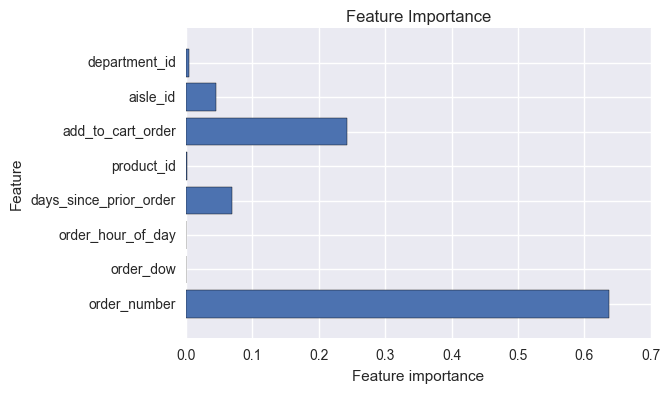

In [65]:
n_features = X.shape[1]
plt.figure()
plt.barh(range(n_features), rfc.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

### Pipeline

In [66]:
#pipeline 5 algorithms
clf1 = LogisticRegression(penalty='l2', C=0.001)
clf2 = DecisionTreeClassifier(max_depth=10, criterion='entropy')
clf3 = KNeighborsClassifier(n_neighbors=25, p = 2, metric='minkowski')
clf4 = ensemble.RandomForestClassifier(n_estimators=25,max_features=8, max_depth=20)
clf5 = GradientBoostingClassifier()
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe2 = Pipeline([['sc', StandardScaler()], ['clf', clf2]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
pipe4 = Pipeline([['sc', StandardScaler()], ['clf', clf4]])
pipe5 = Pipeline([['sc', StandardScaler()], ['clf', clf5]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN', 'Random Forest','Gradient Boosting']
print('10-fold cross validation')
for clf, label in zip([pipe1, pipe2,pipe3, pipe4,pipe5], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    a_scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    f1_scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='f1')
    print("ROC AUC: %0.2f (+/- %0.2f) | Accuracy: %0.2f (+/- %0.2f) | f1 Score: %0.2f (+/- %0.2f) [%s]" % 
          (scores.mean(), scores.std(), a_scores.mean(), a_scores.std(), f1_scores.mean(), f1_scores.std(), label))

10-fold cross validation
ROC AUC: 0.70 (+/- 0.00) | Accuracy: 0.72 (+/- 0.00) | f1 Score: 0.83 (+/- 0.00) [Logistic Regression]
ROC AUC: 0.74 (+/- 0.00) | Accuracy: 0.74 (+/- 0.00) | f1 Score: 0.83 (+/- 0.00) [Decision Tree]
ROC AUC: 0.71 (+/- 0.00) | Accuracy: 0.73 (+/- 0.00) | f1 Score: 0.83 (+/- 0.00) [KNN]
ROC AUC: 0.74 (+/- 0.00) | Accuracy: 0.74 (+/- 0.00) | f1 Score: 0.83 (+/- 0.00) [Random Forest]
ROC AUC: 0.74 (+/- 0.00) | Accuracy: 0.75 (+/- 0.00) | f1 Score: 0.84 (+/- 0.00) [Gradient Boosting]


Let us see all the models and compare the results we got.

In [67]:
accuracy = [{'Model':'Ridge Regression','Accuracy': 0.715,'AUC':0.537},
            {'Model':'Logistic Regression','Accuracy': 0.719,'AUC':0.551},
            {'Model':'KNN Classifier','Accuracy': 0.717,'AUC':0.625},
            {'Model':'Decision Tree Classifier','Accuracy': 0.738,'AUC':0.512},
            {'Model':'Gradient Boosted Classifier','Accuracy': 0.75,'AUC':0.606},
            {'Model':'Bagging','Accuracy': 0.734,'AUC':0.621},
            {'Model':'Random Forest Classifier','Accuracy': 0.737,'AUC':0.600},
            ]
accuracy_df = pd.DataFrame(accuracy)

In [68]:
accuracy_df

,AUC,Accuracy,Model
0,0.537,0.715,Ridge Regression
1,0.551,0.719,Logistic Regression
2,0.625,0.717,KNN Classifier
3,0.512,0.738,Decision Tree Classifier
4,0.606,0.750,Gradient Boosted Classifier
5,0.621,0.734,Bagging
6,0.600,0.737,Random Forest Classifier


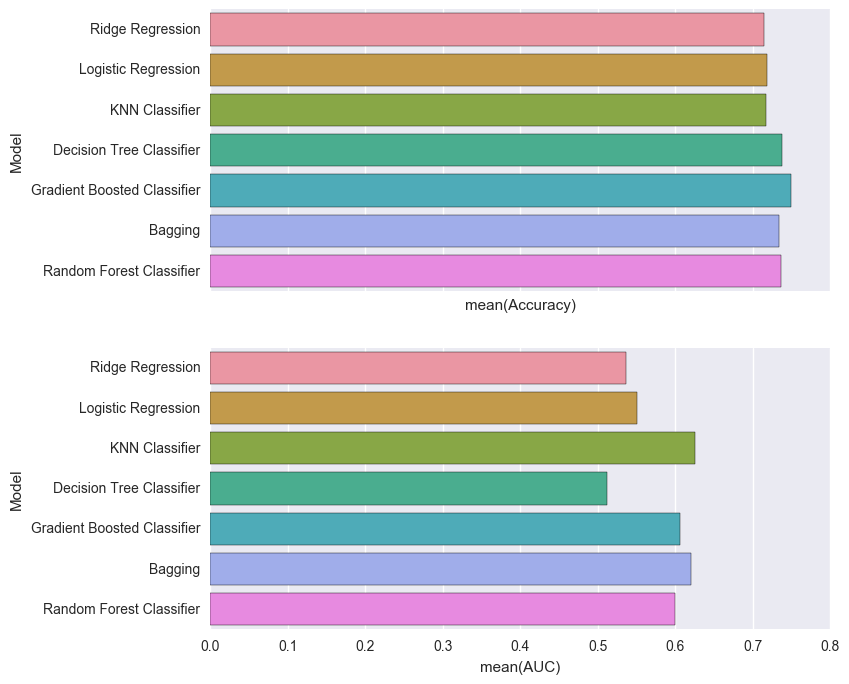

In [69]:
f,(ax1, ax2) = plt.subplots(2,1,figsize = (8,8), sharex = True)
sns.barplot(x = "Accuracy", y= "Model", data=accuracy_df , ax = ax1)
sns.barplot(x = "AUC", y= "Model", data=accuracy_df , ax = ax2)

I also tried the classifier model test on different sample size.Here is the comparative analysis of different sample size and the accuracy of the different models with them.

In [70]:
accuracy_all = [{'Model':'KNN','50K':0.628,'100k':0.663,'500K':0.660,'3 million':0.717},
               {'Model':'Decision Tree','50K':0.686,'100k':0.703,'500K':0.703,'3 million':0.738},
               {'Model':'Bagging','50K':0.693,'100k':0.691,'500K':0.691,'3 million': 0.734},
               {'Model':'Gradient boosted decision Tree','50K':0.71,'100k':0.71,'500K':0.71,'3 million': 0.750},
               {'Model':'Random Forest','50K':0.700,'100k':0.695,'500K':0.697,'3 million':0.737},
               {'Model':'Ridge Regression','50K':0.662,'100k':0.669,'500K':0.666,'3 million':0.715},
               {'Model':'Logistic Regression','50K':0.674,'100k':0.676,'500K':0.676,'3 million':0.719}               
              ]
accuracy_df1 = pd.DataFrame(accuracy_all)

In [71]:
accuracy_df1

,100k,3 million,500K,50K,Model
0,0.663,0.717,0.660,0.628,KNN
1,0.703,0.738,0.703,0.686,Decision Tree
2,0.691,0.734,0.691,0.693,Bagging
3,0.710,0.750,0.710,0.710,Gradient boosted decision Tree
4,0.695,0.737,0.697,0.700,Random Forest
5,0.669,0.715,0.666,0.662,Ridge Regression
6,0.676,0.719,0.676,0.674,Logistic Regression


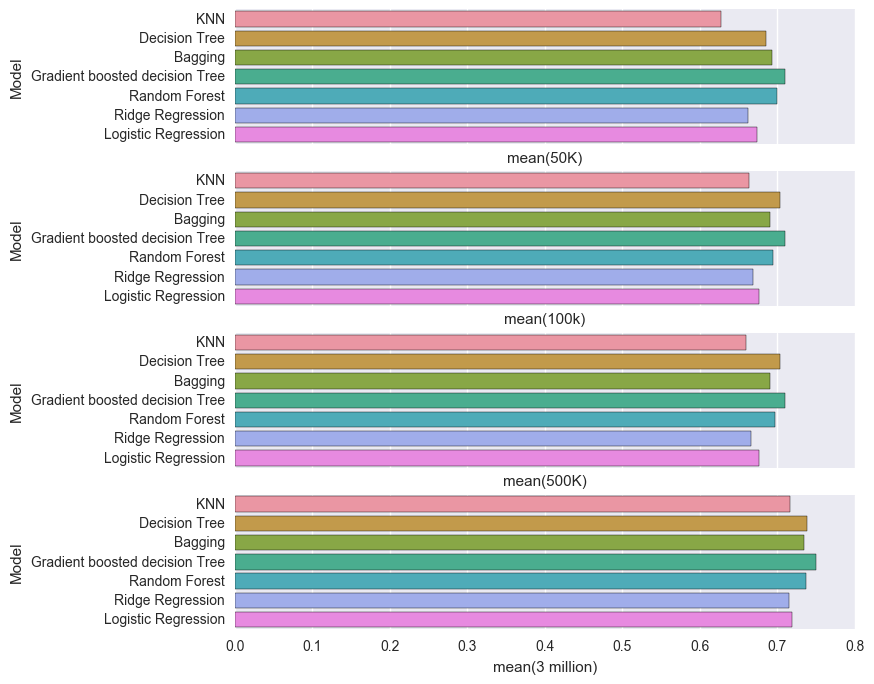

In [72]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize = (8,8), sharex = True)
sns.barplot(x = "50K", y= "Model", data=accuracy_df1 , ax = ax1)
sns.barplot(x = "100k", y= "Model", data=accuracy_df1 , ax = ax2)
sns.barplot(x = "500K", y= "Model", data=accuracy_df1 , ax = ax3)
sns.barplot(x = "3 million", y= "Model", data=accuracy_df1 , ax = ax4);

### Conclusion

After running the different classifier models with different ssample sizes it can be concluded that more the sample size more is the accuracy of the model.
Standardizing features by removing the mean and scaling to unit variance helps to increase the accuracy as well as AUC of the model.
Gradient boosting of decision tree is the best performing model among all the models tried in this notebook.

There is further scope of improvement if larger sample size is used.
SVM model gives highest accuracy among all but due to computational limitation couldnt try with larger sample sizes.



### Referances:

https://www.kaggle.com/c/instacart-market-basket-analysis

http://scikit-learn.org/stable/    